### Testing the labeled_test_17k data with both the train and the unlabeled data (predicted by LSTM) model

- The training data used here was the combination of the train(labeled_10k.csv) and the predicted(unlabeled_70k.csv)
- The (unlabeled_70k.csv) was predicted using the LSTM model, the code for that is avialble in the 'Predicting Unlabelled Data with LSTM model.ipynb' file
- Further the ouput of this file is saved in a results.pkl file, which is a dataframe containing all the predicted values for each moment from the test data

In [1]:
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.models import load_model
from keras.layers import Bidirectional

from nltk.tokenize import word_tokenize
import pandas as pd 
import numpy as np
import re
import tensorflow as tf
from matplotlib import pyplot as plt



from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from numpy import array
from numpy import asarray
from numpy import zeros

### Loading Pickle files 

Loading the labeled training dataset; stored in the train.pkl file

In [2]:
df = pd.read_pickle('train.pkl')
df

,hmid,moment,social,agency
0,27674,i happy my son got marks his examination,1,0
1,27685,went movies my friends it fun,1,1
2,27691,hot kiss my girl friend last night made my day,1,1
3,27701,my son woke me fantastic breakfast eggs his sp...,1,0
4,27712,my older daughter keeps patting my younger dau...,1,0
...,...,...,...,...
10555,128748,my husband called me tell me he loved me,1,0
10556,128753,i worked always makes me feel good,0,1
10557,128754,finally got watch new resident evil movie,0,1
10558,128757,i got talk old friend reminisce good times,1,1


Loading the predicted unlabeled dataset; stored in the predicted_unlabeled.pkl

In [3]:
df_2 = pd.read_pickle('predicted_unlabeled_data.pkl')
df_2

,hmid,moment,social,agency
0,27673,i went successful date someone i felt sympathy...,0,1
1,27675,i went gym morning yoga,0,1
2,27678,i meditated last night,0,1
3,27679,i made new recipe peasant bread it came specta...,0,1
4,27680,i got gift my elder brother really surprising me,1,0
...,...,...,...,...
69828,128761,i spent time my daughter,1,1
69829,128762,my husband announced he getting decent bonus q...,1,0
69830,128763,pepsi drink,0,1
69831,128764,cuddling my girlfriend last night,1,1


#### Concatinating both the dataset to use them as train dataset to check the results on the test dataset

In [4]:
train_df = pd.concat([df, df_2])
train_df = train_df.reset_index()
train_df = train_df[['hmid','moment','social','agency']]

In [5]:
train_df

,hmid,moment,social,agency
0,27674,i happy my son got marks his examination,1,0
1,27685,went movies my friends it fun,1,1
2,27691,hot kiss my girl friend last night made my day,1,1
3,27701,my son woke me fantastic breakfast eggs his sp...,1,0
4,27712,my older daughter keeps patting my younger dau...,1,0
...,...,...,...,...
79749,128761,i spent time my daughter,1,1
79750,128762,my husband announced he getting decent bonus q...,1,0
79751,128763,pepsi drink,0,1
79752,128764,cuddling my girlfriend last night,1,1


Loading the test dataset

In [6]:
test_df = pd.read_pickle('test.pkl')
test_df.name = "Test Dataset"
test_df.head()

,hmid,moment,social,agency
0,0,i able spend day my fiance shopping yesterday,0,1
1,1,i able play my cat,0,1
2,2,i able clean my room gold my laundry,0,1
3,3,i spend day party beach i happy see friends i ...,1,1
4,4,my cat greeting me i got home work she sweet c...,0,0


Seperating the X and y features for both the train and test dataset

In [7]:
X_train = train_df['moment'].values
y_train_social = train_df['social'].values
y_train_agency = train_df['agency'].values

In [8]:
X_test = test_df['moment'].values
y_test_social = test_df['social'].values
y_test_agency = test_df['agency'].values

#### Some statistical insights about our datasets

The TRAIN dataset

In [9]:
import statistics
length = 0
val = ""
train_avg = []
for sentence in X_train:
    sen_len = len(word_tokenize(sentence))
    train_avg.append(sen_len)
    if sen_len > length:
        length = sen_len
        val = sentence
print(f'Sentence : {val}\nLength :{length}')
print(f'Average Sentence Length : {sum(train_avg) / len(train_avg)}')
print(f'Standard Dev : {statistics.pstdev(train_avg)}') 

Sentence : morning i coming home shop i saw little boy standing quite looking parents who caring children buying something them little boy watching them i watching him i went him asked hey u little boy who you you standing he replied i lost my parents church i bring boy police station i told boy police all us sudden parents came embresed little boy i felt like something i something good describe me made my day i happy see them happy i really happy see smile face boy he looked me he smiled me gave fly kiss 
Length :95
Average Sentence Length : 9.081926925295283
Standard Dev : 4.810404253782868


The TEST dataset

In [10]:
length = 0
val = ""
test_avg = []
for sentence in X_test:
    sen_len = len(word_tokenize(sentence))
    test_avg.append(sen_len)
    if sen_len > length:
        length = sen_len
        val = sentence
print(f'Sentence : {val}\nLength :{length}')
print(f'Average Sentence Length : {sum(test_avg) / len(test_avg)}')

Sentence : event i would know it big small i bought my car made me happy long time hard work buy it i could it it made me happy past i tried raise money buy it everything resulted failure something damaged i buy something new even large part my money stolen i forgot my portfolio somewhere my nephew hid me my carelessness i lost money my father helped me replenish part money working long time i managed buy it i realized great effort i achieve anything i want 
Length :86
Average Sentence Length : 9.36282311937264


#### The following code block is used to : 
- Convert texts to sequence
- Then pad these sequences based on the max_len variable which is 25 in our case
- The max_len = 25 variable was choosen based on the criteria that majority of the sentences did fit under this value, which eventually enables us to have a dense matrix.
- Values 9 and 10 were also considered as the max_len val but did not produce promising results. They were choosen based on the fact that the average length of a sentence in this corpora is 9.36 (after text pre-processing)

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 25

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [12]:
X_train.shape, X_test.shape

((79754, 25), (17215, 25))

#### Printing the top rows both text and numerical
- This gives us an idea of how the 1st value is converted to vector of 25 dimensions


In [13]:
print(train_df['moment'][0])
print(X_train[0])

i happy my son got marks his examination 
[   1    4    2   34    5 1633   42 1945    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


#### The following code block is used to build an embedding matrix with the following configuration

- Glove Embedding with 300 dimensions

In [14]:
embeddings_dictionary = dict()

glove_file = open('glove.6B/glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Method to test the Accuracy, Precision, Recall and F1 Score


The following method transforms the output to binary values before calculating the scores

In [15]:
def transformResults(predictions):
    print("""The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0""")
    
    print("\nConverting the ouput to 1D array, and then transformimg the values based on the above condition\n")
    predictions = predictions[:, 0]
    print(f'First 5 values before conversion : {predictions[:5]}')
    
    predictions = [1 if val>0.5 else 0 for val in predictions]
    print(f'First 5 values after the conversion : {predictions[:5]}')
    return predictions

In [16]:
def getResults(y_test, model_prediction):
    model_prediction = transformResults(model_prediction)
    print("\n========== RESULTS ===========\n")
    accuracy = accuracy_score(y_test, model_prediction)
    precision = precision_score(y_test, model_prediction)
    f1 = f1_score(y_test, model_prediction)
    recall = recall_score(y_test, model_prediction)
    print(f'Accuracy : {accuracy}\nPrecision : {precision}\nF1_score : {f1}\nRecall : {recall}\n')
    
    print("===== CONFUSION MATRIX =====")
    cf_matrix = confusion_matrix(y_test_social, model_prediction)
    print(cf_matrix)
    
    return accuracy, precision, f1, recall

### Building the LSTM model 
with Embedding layer, LSTM layer and Dense layer with a single unit

This will be seperately evaluated for both the social and agency labels

In [17]:
def getLSTMModel():
    deep_inputs = Input(shape=(maxlen,))
    embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(deep_inputs)
    LSTM_Layer_1 = LSTM(128)(embedding_layer)
    dense_layer_1 = Dense(1, activation='sigmoid')(LSTM_Layer_1)
    model = Model(inputs=deep_inputs, outputs=dense_layer_1)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    print(model.summary())
    return model

In [18]:
model = getLSTMModel()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 25, 300)           5736600   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 5,956,377
Trainable params: 219,777
Non-trainable params: 5,736,600
_________________________________________________________________
None


### Fit the model for the Social label

In [19]:
history = model.fit(X_train, y_train_social, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
499/499 [==============================] - 25s 46ms/step - loss: 0.2301 - acc: 0.9066 - val_loss: 0.0830 - val_acc: 0.9721
Epoch 2/10
499/499 [==============================] - 23s 46ms/step - loss: 0.1039 - acc: 0.9638 - val_loss: 0.0703 - val_acc: 0.9763
Epoch 3/10
499/499 [==============================] - 23s 47ms/step - loss: 0.0899 - acc: 0.9701 - val_loss: 0.0604 - val_acc: 0.9782
Epoch 4/10
499/499 [==============================] - 24s 47ms/step - loss: 0.0836 - acc: 0.9730 - val_loss: 0.0602 - val_acc: 0.9797
Epoch 5/10
499/499 [==============================] - 24s 47ms/step - loss: 0.0696 - acc: 0.9787 - val_loss: 0.0667 - val_acc: 0.9782
Epoch 6/10
499/499 [==============================] - 24s 48ms/step - loss: 0.0673 - acc: 0.9799 - val_loss: 0.0627 - val_acc: 0.9767
Epoch 7/10
499/499 [==============================] - 25s 51ms/step - loss: 0.0598 - acc: 0.9824 - val_loss: 0.0662 - val_acc: 0.9779
Epoch 8/10
499/499 [==============================] - 26s 52ms

In [20]:
social_predictions = model.predict(X_test)
print(social_predictions[:,0])

[0.99539614 0.00435391 0.00342596 ... 0.999225   0.05949804 0.00327051]


In [21]:
social_results = getResults(y_test_social, social_predictions)

The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0

Converting the ouput to 1D array, and then transformimg the values based on the above condition

First 5 values before conversion : [0.99539614 0.00435391 0.00342596 0.9919095  0.97762513]
First 5 values after the conversion : [1, 0, 0, 1, 1]

========== RESULTS ===========

Accuracy : 0.9105431309904153
Precision : 0.9619601700604162
F1_score : 0.917805294619983
Recall : 0.8775260257195346

===== CONFUSION MATRIX =====
[[7077  340]
 [1200 8598]]


### Fit the model for the Agency Label

In [22]:
history = model.fit(X_train, y_train_agency, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
499/499 [==============================] - 35s 70ms/step - loss: 0.2541 - acc: 0.9031 - val_loss: 0.1203 - val_acc: 0.9526
Epoch 2/10
499/499 [==============================] - 30s 60ms/step - loss: 0.1467 - acc: 0.9466 - val_loss: 0.1273 - val_acc: 0.9485
Epoch 3/10
499/499 [==============================] - 28s 56ms/step - loss: 0.1304 - acc: 0.9553 - val_loss: 0.0986 - val_acc: 0.9613
Epoch 4/10
499/499 [==============================] - 29s 59ms/step - loss: 0.1180 - acc: 0.9607 - val_loss: 0.1006 - val_acc: 0.9598
Epoch 5/10
499/499 [==============================] - 28s 57ms/step - loss: 0.1086 - acc: 0.9651 - val_loss: 0.1082 - val_acc: 0.9584
Epoch 6/10
499/499 [==============================] - 31s 61ms/step - loss: 0.0991 - acc: 0.9688 - val_loss: 0.1033 - val_acc: 0.9610
Epoch 7/10
499/499 [==============================] - 26s 52ms/step - loss: 0.0903 - acc: 0.9728 - val_loss: 0.1083 - val_acc: 0.9608
Epoch 8/10
499/499 [==============================] - 28s 57ms

In [23]:
agency_predictions = model.predict(X_test)
print(agency_predictions[:,0])

[0.996994   0.9966028  0.997203   ... 0.95130855 0.990988   0.992264  ]


In [24]:
agency_results = getResults(y_test_agency, agency_predictions)

The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0

Converting the ouput to 1D array, and then transformimg the values based on the above condition

First 5 values before conversion : [0.996994   0.9966028  0.997203   0.9940667  0.04066172]
First 5 values after the conversion : [1, 1, 1, 1, 0]

========== RESULTS ===========

Accuracy : 0.8310194597734534
Precision : 0.8704430734716769
F1_score : 0.8819255591183991
Recall : 0.8937150378413952

===== CONFUSION MATRIX =====
[[ 895 6522]
 [3839 5959]]


### ACCURACY scores for social and agency label with LSTM model

<Figure size 432x288 with 0 Axes>

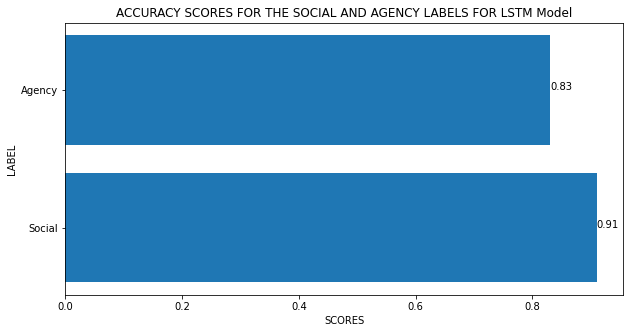

In [25]:
fig = plt.figure()
fig = plt.figure(figsize = (10, 5))
label = ['Social', 'Agency']
scores = [social_results[0], agency_results[0]]
plt.ylabel("LABEL")
plt.xlabel("SCORES")
plt.barh(label,scores)
plt.title("ACCURACY SCORES FOR THE SOCIAL AND AGENCY LABELS FOR LSTM Model")
for index, value in enumerate(scores):
    plt.text(value, index, str(round(value, 2)))
plt.show()

### Building a dataframe for the predicted values

- We were able to get a minor update for the accuracy values for the social label and the final accuracy for the social label is : 0.91 using the LSTM model( wiht Glove embedding 300 dim) trained on the (train data + predicted unlabelled data) The unlabelled data was predicted using the LSTM model( with glove embedding 300 dim)

- Building a dataframe which contains the columns for the predicted values for 

In [63]:
results = pd.read_csv('data/TEST/labeled_17k.csv')
results

,hmid,moment,reflection,age,country,gender,duration,married,parenthood,concepts,agency,social
0,0,I was able to spend the day with my fiance sho...,24h,28,USA,m,all_day_im_still_feeling_it,single,n,shopping|family|romance,yes,no
1,1,I was able to play with my cat.,24h,28,USA,m,at_least_one_hour,single,n,animals,yes,no
2,2,I was able to clean my room and gold my laundry.,24h,28,USA,m,at_least_one_hour,single,n,0,yes,no
3,3,I spend the day at a party on the beach and I ...,24h,24,USA,m,half_a_day,single,n,vacation|party|weather,yes,yes
4,4,My cat greeting me when I got home from work -...,24h,24,USA,m,half_a_day,single,n,animals,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...
17210,21892,My wife and I went for a hike last week and we...,3m,34,USA,m,half_a_day,married,n,romance|exercise|family,yes,yes
17211,21893,I finally hit platinum rank in Overwatch.,3m,34,USA,m,at_least_one_hour,married,n,entertainment,yes,no
17212,21897,One of my long-time friends and I finally ackn...,3m,34,USA,m,all_day_im_still_feeling_it,single,n,romance,yes,yes
17213,21898,I earned a professional certification.,3m,34,USA,m,half_a_day,single,n,career|education,yes,no


Reducing the coluumns to hmid, moment, social, agency values

In [64]:
results = results[['hmid','moment','social','agency']]
results

,hmid,moment,social,agency
0,0,I was able to spend the day with my fiance sho...,no,yes
1,1,I was able to play with my cat.,no,yes
2,2,I was able to clean my room and gold my laundry.,no,yes
3,3,I spend the day at a party on the beach and I ...,yes,yes
4,4,My cat greeting me when I got home from work -...,no,no
...,...,...,...,...
17210,21892,My wife and I went for a hike last week and we...,yes,yes
17211,21893,I finally hit platinum rank in Overwatch.,no,yes
17212,21897,One of my long-time friends and I finally ackn...,yes,yes
17213,21898,I earned a professional certification.,no,yes


In [67]:
social_pred = pd.DataFrame(social_predictions[:,0], columns=['social_predicted'])
agency_pred = pd.DataFrame(agency_predictions[:,0], columns=['agency_predicted'])

In [68]:
display(social_pred.head())
display(agency_pred.head())

,social_predicted
0,0.995396
1,0.004354
2,0.003426
3,0.991910
4,0.977625


,agency_predicted
0,0.996994
1,0.996603
2,0.997203
3,0.994067
4,0.040662


Converting both the columns to values 'yes' and 'no' based on the conditions that were used above, where a value > .5 is 'yes' and a value < .5 is 'no'

In [71]:
def getBinary(val):
    if val > .5:
        return 'yes'
    else:
        return 'no'

In [72]:
social_pred['social_predicted'] = social_pred['social_predicted'].apply(getBinary)
agency_pred['agency_predicted'] = agency_pred['agency_predicted'].apply(getBinary)

In [73]:
display(social_pred.head())
display(agency_pred.head())

,social_predicted
0,yes
1,no
2,no
3,yes
4,yes


,agency_predicted
0,yes
1,yes
2,yes
3,yes
4,no


Converting the binary values to yes and no

In [74]:
results['social_predicted'] = social_pred['social_predicted']
results['agency_predicted'] = agency_pred['agency_predicted']

<ipython-input-74-4fec54adb2eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['social_predicted'] = social_pred['social_predicted']
<ipython-input-74-4fec54adb2eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['agency_predicted'] = agency_pred['agency_predicted']


In [75]:
results

,hmid,moment,social,agency,social_predicted,agency_predicted
0,0,I was able to spend the day with my fiance sho...,no,yes,yes,yes
1,1,I was able to play with my cat.,no,yes,no,yes
2,2,I was able to clean my room and gold my laundry.,no,yes,no,yes
3,3,I spend the day at a party on the beach and I ...,yes,yes,yes,yes
4,4,My cat greeting me when I got home from work -...,no,no,yes,no
...,...,...,...,...,...,...
17210,21892,My wife and I went for a hike last week and we...,yes,yes,yes,yes
17211,21893,I finally hit platinum rank in Overwatch.,no,yes,no,yes
17212,21897,One of my long-time friends and I finally ackn...,yes,yes,yes,yes
17213,21898,I earned a professional certification.,no,yes,no,yes


Saving this dataframe

In [76]:
pd.to_pickle(results,'predicted_data.pkl')